# Attention

[CE477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Ramtin Moslemi


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_05_Natural_Language_Processing/Attention.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_05_Natural_Language_Processing/Attention.ipynb)

---

## Notebook Objectives

In this notebook, we are going to implement the attention layers from scratch using PyTorch and learn more about Transformers.



In [1]:
# @title Install dependencies
!pip install transformers --quiet
!pip install datasets --quiet

In [2]:
# @title Imports

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix


import torch
from torch import nn
from torch import optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from datasets import load_dataset
from transformers import AutoTokenizer


torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# @title helper functions

def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for training.

    Returns:
        Tuple[float, float]: Training loss and accuracy.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = nn.NLLLoss()

    for batch in (pbar := tqdm(train_loader, leave=False)):
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        accuracy = 100 * correct / total
        pbar.set_description(f'Train Accuracy = {accuracy:.2f}% | Loss = {loss.item():.3f} ')

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy


def evaluate(model: nn.Module, test_loader: DataLoader):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.

    Returns:
        Tuple[float, float]: Test loss and accuracy.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = nn.NLLLoss()

    with torch.no_grad():

        for batch in (pbar := tqdm(test_loader, leave=False)):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
            pbar.set_description(f'Test Accuracy = {accuracy:.2f}% | Loss = {loss.item():.3f} ')

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy



def test(model: nn.Module, test_loader: DataLoader, classes: dict):
    """
    Test the model on the test data and plot confusion matrix.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        classes (dict): Dictionary with class indices as keys and class names as values.

    Returns:
        Tuple[float, float]: Test loss and accuracy.
    """
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_display_labels = [classes[i] for i in range(len(classes))]

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, n_epochs: int = 1, learning_rate: float = 1e-4):
    """
    Run gradient descent to optimize parameters of a given network.

    Args:
        model (nn.Module): PyTorch network whose parameters to optimize.
        train_loader (DataLoader): DataLoader with training data.
        test_loader (DataLoader): DataLoader with test data.
        n_epochs (int, optional): Number of iterations of gradient descent to run. Default is 1.
        learning_rate (float, optional): Learning rate to use for gradient descent. Default is 1e-4.

    Returns:
        Tuple[List[float], List[float]]: Training loss and test loss over iterations.
    """

    # Initialize PyTorch Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Placeholder to save the loss at each iteration
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Loop over epochs
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        pbar.set_description(f'Train Accuracy = {train_acc:.2f}% | Loss = {train_loss:.3f} ')
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        test_loss, test_acc = evaluate(model, test_loader)
        pbar.set_description(f'Test Accuracy = {test_acc:.2f}% | Loss = {test_loss:.3f} ')
        history['val_loss'].append(test_loss), history['val_acc'].append(test_acc)

    plot_training_curves(history)

    return history


def plot_training_curves(results):
    epochs_range = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, results['train_loss'], label='Train Loss')
    plt.plot(epochs_range, results['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs_range, results['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs_range)  # Adding ticks for epochs
    plt.yticks(range(0, 101, 10))  # Accuracy range from 0 to 100
    plt.legend()

    plt.tight_layout()
    plt.show()


def display_predictions(model: nn.Module, test_loader: DataLoader, tokenizer, classes: dict, num_samples: int = 10):
    """
    Display text, predicted probabilities, and true labels for samples from the test loader.

    Args:
        model (nn.Module): The model to use for predictions.
        test_loader (DataLoader): DataLoader for test data.
        tokenizer: Tokenizer used to encode the text data.
        classes (dict): Dictionary with class indices as keys and class names as values.
        num_samples (int): Number of samples to display.
    """
    model.eval()
    samples_shown = 0
    max_seq_len = test_loader.dataset[0]['input_ids'].shape[0]

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)

            for i in range(len(inputs)):
                if samples_shown >= num_samples:
                    return

                # Decode the input text
                input_text = tokenizer.decode(inputs[i], skip_special_tokens=True)

                # Calculate probabilities
                probs = nn.functional.softmax(outputs[i], dim=0)

                # Get true label and predicted probabilities
                true_label = classes[labels[i].item()]
                pred_probs = {classes[j]: probs[j].item() for j in range(len(classes))}

                # Display the results
                print(f"Sample {samples_shown + 1}")
                print(f"Text: {input_text}")
                print(f"True Label: {true_label}")
                print(f"Predicted Probabilities:\n{pd.Series(pred_probs).to_string()}")
                print("=" * 80)

                samples_shown += 1

# AG News Dataset

We will start by downloading the [AG News dataset](https://huggingface.co/datasets/fancyzhx/ag_news).

In [ ]:
# Load the AG News dataset
ag_dataset = load_dataset("ag_news")

# Split the dataset into train and test sets
train_dataset = ag_dataset["train"]
test_dataset = ag_dataset["test"]

classes = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(classes)

Let's take a look at a few samples.

In [5]:
text = train_dataset['text'][40*477]
label = train_dataset['label'][40*477]
print(classes[label], ':', text[:477])

World : Clinton Surgery Expected Early This Week Former President Bill Clinton's heart bypass, expected Monday or Tuesday, likely will be an ordinary replumbing of his ailing heart, not some new whiz-bang robotic or "keyhole" surgery, leading surgeons say.    And just as his operation is likely to be the same as the average American's, the delay in his surgery also suggests a problem typical for many patients: doctors and nurses off for the holiday weekend...


In [6]:
text = train_dataset['text'][2024]
label = train_dataset['label'][2024]
print(classes[label], ':', text[:477])

Sports : Phelps #39;s dreams meet not-so-bad realities ATHENS Imagine, just for the length of a breezy, sun-kissed summer evening in Athens, that you had not heard a word about Michael Phelps before these Olympics began. That you knew nothing about his childhood in Baltimore; the failed Olympic dreams of his ...


## BERT tokenizer

A tokenizer is in charge of preparing the inputs for a model i.e., splitting strings in sub-word token strings, converting tokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers). There are multiple tokenizer variants. [BERT](https://arxiv.org/abs/1810.04805) base model (cased) has been used here. BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. Pretrained model on English language using a masked language modeling (MLM) objective. For more information, see [here](https://huggingface.co/bert-base-cased).

In [7]:
# Load the pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 48
vocab_size = tokenizer.vocab_size

# Tokenization function
def preprocess(texts, labels, max_length=max_len):
    inputs = tokenizer(texts, padding='max_length', truncation=True,
                       max_length=max_length, return_tensors='pt')
    inputs['labels'] = torch.tensor(labels)
    return inputs


# Preprocess the training data
train_inputs = preprocess(train_dataset['text'], train_dataset['label'])

# Preprocess the test data
test_inputs = preprocess(test_dataset['text'], test_dataset['label'])

## Datasets and DataLoaders

In [8]:
# Create custom Dataset class

class AGNewsDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item

# Create DataLoader instances
train_dataset = AGNewsDataset(train_inputs)
test_dataset = AGNewsDataset(test_inputs)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
len(train_dataset), len(test_dataset)

(120000, 7600)

# Attention Mechanism



We start by implementing the scaled dot product attention:

\begin{equation}
\mathrm{softmax} \left( \frac{Q K^\text{T}}{\sqrt{d}} \right) V
\end{equation}

where $Q$ denotes the query or values of the embeddings (in other words the hidden states), $K$ the key, and $k$ denotes the dimension of the query key vector.

The division by square-root of d is to stabilize the gradients.

In [10]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    def __init__(self, dropout: float):
        """
        Constructs a Scaled Dot Product Attention instance.

        Args:
            dropout (float): Probability of dropout hyperparameter.
        """
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def calculate_score(self, queries: Tensor, keys: Tensor) -> Tensor:
        """
        Compute the score between queries and keys.

        Args:
            queries (Tensor): Queries with shape (batch_size, num_queries, head, k).
            keys (Tensor): Keys with shape (batch_size, num_key_value_pairs, head, k).

        Returns:
            Tensor: The computed scores.
        """
        return torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])

    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, batch_size: int, num_heads: int, seq_length: int, dim_k: int) -> Tensor:
        """
        Compute dot products for attention mechanism.

        Args:
            queries (Tensor): Queries with shape (batch_size, num_queries, head, k).
            keys (Tensor): Keys with shape (batch_size, num_key_value_pairs, head, k).
            values (Tensor): Values with shape (batch_size, head, num_key_value_pairs, k).
            batch_size (int): Batch size.
            num_heads (int): Number of attention heads.
            seq_length (int): Sequence length (number of queries/keys/values).
            dim_k (int): Embedding size.

        Returns:
            Tensor: Output of the attention mechanism.
        """
        keys = keys.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        values = values.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)

        # Matrix multiplication between the keys and queries
        score = self.calculate_score(queries, keys)  # shape: (batch_size * num_heads, seq_length, seq_length)
        softmax_weights = F.softmax(score, dim=2)  # row-wise normalization of weights

        # Matrix multiplication between the score and values
        out = torch.bmm(self.dropout(softmax_weights), values).view(batch_size, num_heads, seq_length, dim_k)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * dim_k)

        return out


In self-attention, the queries, keys, and values are all mapped (by linear projection) from the word embeddings. Implement the mapping functions (`to_keys`, `to_queries`, `to_values`) below.

# Multi-Head Attention


One powerful idea in Transformer is multi-head attention, which is used to capture different aspects of the dependence among words (e.g., syntactical vs semantic). Self-attention layers can model dependencies between all elements in an input sequence in parallel, capturing long-range relationships efficiently.


In [11]:
class SelfAttention(nn.Module):
    """Multi-head self-attention layer."""

    def __init__(self, embed_dim: int, num_heads: int = 8, dropout: float = 0.1):
        """
        Initializes the SelfAttention layer.

        Args:
            embed_dim (int): Size of attention embeddings.
            num_heads (int): Number of attention heads. Default is 8.
            dropout (float): Dropout probability. Default is 0.1.
        """
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.to_keys = nn.Linear(embed_dim, embed_dim * num_heads, bias=False)
        self.to_queries = nn.Linear(embed_dim, embed_dim * num_heads, bias=False)
        self.to_values = nn.Linear(embed_dim, embed_dim * num_heads, bias=False)
        self.unify_heads = nn.Linear(embed_dim * num_heads, embed_dim)

        self.attention = DotProductAttention(dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Performs the forward pass of the self-attention layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).

        Returns:
            Tensor: Output tensor after applying self-attention.
        """
        batch_size, seq_length, embed_dim = x.size()
        num_heads = self.num_heads

        # Reshape the queries, keys, and values so that each head has its own dimension
        queries = self.to_queries(x).view(batch_size, seq_length, num_heads, embed_dim)
        keys = self.to_keys(x).view(batch_size, seq_length, num_heads, embed_dim)
        values = self.to_values(x).view(batch_size, seq_length, num_heads, embed_dim)

        out = self.attention(queries, keys, values, batch_size, num_heads, seq_length, embed_dim)

        return self.unify_heads(out)

In practice PyTorch's `torch.nn.MultiheadAttention()` function is used and you can learn more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).

# Transformer Encoder



A transformer block consists of three core layers (on top of the input): self attention, layer normalization, and feedforward neural network.

Implement the forward function below by composing the given modules (`SelfAttention`, `LayerNorm`, and `MLP`) according to the diagram below.

![transformer-encoder](https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D5_AttentionAndTransformers/static/transformers1.png)

You can see an implementation of the Transformer Encoder Blocks below.

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps in stabilizing the training of models. You can learn more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

In [12]:
class TransformerBlock(nn.Module):
    """Block to instantiate transformers."""

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Initializes the Transformer block.

        Args:
            embed_dim (int): Size of attention embeddings.
            num_heads (int): Number of self-attention heads.
        """
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_dim, num_heads=num_heads)

        self.norm_1 = nn.LayerNorm(embed_dim)
        self.norm_2 = nn.LayerNorm(embed_dim)

        hidden_size = 2 * embed_dim  # This is a somewhat arbitrary choice
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Defines the forward pass through the transformer block.

        Args:
            x (Tensor): Input tensor with shape (batch_size, seq_length, embed_dim).

        Returns:
            Tensor: Output tensor after processing through the transformer block.
        """
        attended = self.attention(x)
        x = self.norm_1(attended + x)  # First Add & Normalize layer

        feedforward = self.mlp(x)
        x = self.norm_2(feedforward + x)  # Second Add & Normalize layer

        return x

In practice PyTorch's `torch.nn.Transformer()` layer is used and you can learn more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html).

# Positional Encoding


Self-attention is concerned with relationship between words and is not sensitive to positions or word orderings.
Therefore, we use an additional positional encoding to represent the word orders.

There are multiple ways to encode the position. For our purpose to have continuous values of the positions based on binary encoding, let's use the following implementation of deterministic (as opposed to learned) position encoding using sinusoidal functions.

\begin{equation}
PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})\\
PE_{(pos,2i+1)}= \cos(pos/10000^{2i/d_{model}})
\end{equation}

![positional-embeddings](https://upload.wikimedia.org/wikipedia/commons/0/02/Positional_encoding.png)

Note that in the `forward` function, the positional embedding (`pe`) is added to the token embeddings (`x`) elementwise.



In [13]:
class PositionalEncoding(nn.Module):
  # Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
  """ Block initiating Positional Encodings """

  def __init__(self, emb_size, dropout=0.1, max_len=512):
    """
    Constructs positional encodings
    Positional Encodings inject some information about the relative or absolute position of the tokens in the sequence.

    Args:
      emb_size: Integer
        Specifies embedding size
      dropout: Float
        Specifies Dropout probability hyperparameter
      max_len: Integer
        Specifies maximum sequence length

    Returns:
      Nothing
    """
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, emb_size)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))

    # Each dimension of the positional encoding corresponds to a sinusoid.
    # The wavelengths form a geometric progression from 2π to 10000·2π.
    # This function is chosen as it's hypothesized that it would allow the model
    # to easily learn to attend by relative positions, since for any fixed offset k,
    # PEpos + k can be represented as a linear function of PEpos.
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    """
    Defines network structure

    Args:
      x: Tensor
        Input sequence

    Returns:
      x: Tensor
        Output is of the same shape as input with dropout and positional encodings
    """
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)


# Full Transformer Architecture

Now it's time to put all of these layers together!

In [14]:
class Transformer(nn.Module):
    """Transformer Encoder network for classification."""

    def __init__(self, embed_dim: int, num_heads: int, depth: int, seq_length: int, num_tokens: int, num_classes: int):
        """
        Initializes the Transformer network.

        Args:
            embed_dim (int): Attention embedding size.
            num_heads (int): Number of self-attention heads.
            depth (int): Number of Transformer blocks.
            seq_length (int): Length of input sequence.
            num_tokens (int): Size of dictionary.
            num_classes (int): Number of output classes.
        """
        super(Transformer, self).__init__()

        self.embed_dim = embed_dim
        self.num_tokens = num_tokens
        self.token_embedding = nn.Embedding(num_tokens, embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim)

        transformer_blocks = [TransformerBlock(embed_dim=embed_dim, num_heads=num_heads) for _ in range(depth)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass for classification within the Transformer network.

        Args:
            x (Tensor): Input tensor of tokenized words with shape (batch_size, seq_length).

        Returns:
            Tensor: Log-probabilities over classes with shape (batch_size, num_classes).
        """
        x = self.token_embedding(x) * np.sqrt(self.embed_dim)
        x = self.pos_enc(x)
        x = self.transformer_blocks(x)

        sequence_avg = x.mean(dim=1)
        x = self.classification_head(sequence_avg)
        logprobs = F.log_softmax(x, dim=1)
        return logprobs

# Training the Transformer



Let's now run the Transformer on the AG News dataset!

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

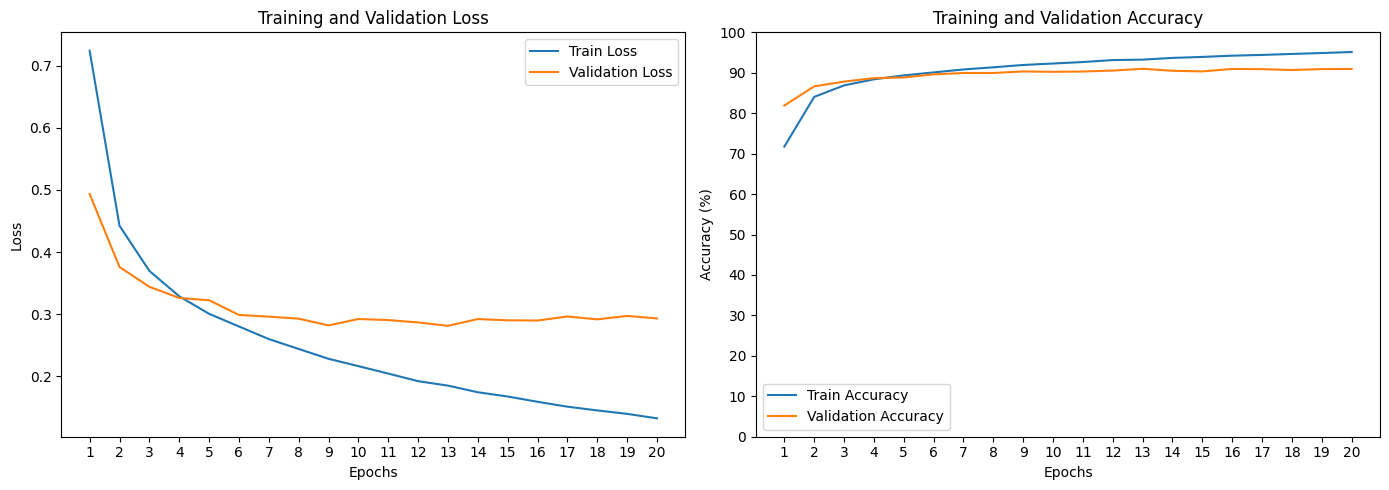

In [15]:
# Initialize network with embedding size 128, 8 attention heads, and 3 layers
model = Transformer(128, 8, 3, max_len, vocab_size, num_classes).to(device)

# Train the model
results = train(model, train_loader=train_loader, test_loader=test_loader, n_epochs=10)

# Results


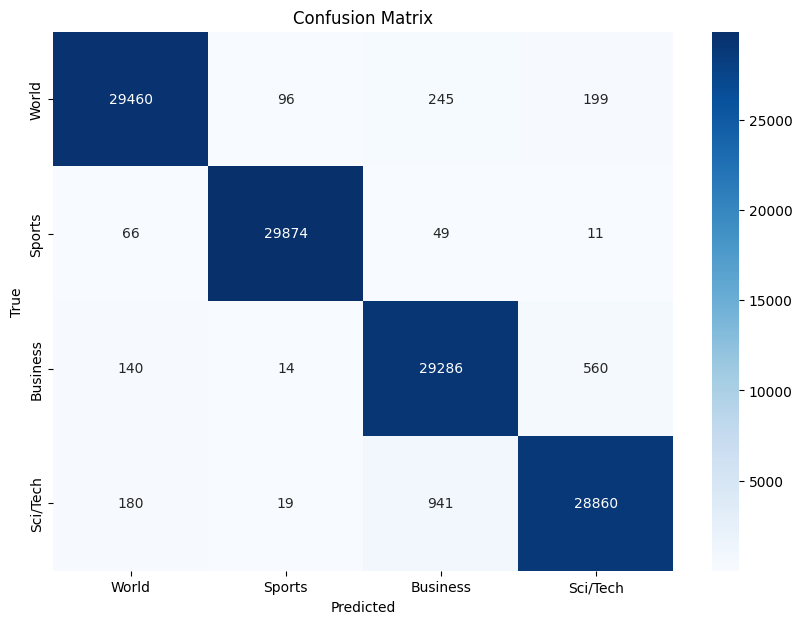

In [17]:
test(model, train_loader, classes)

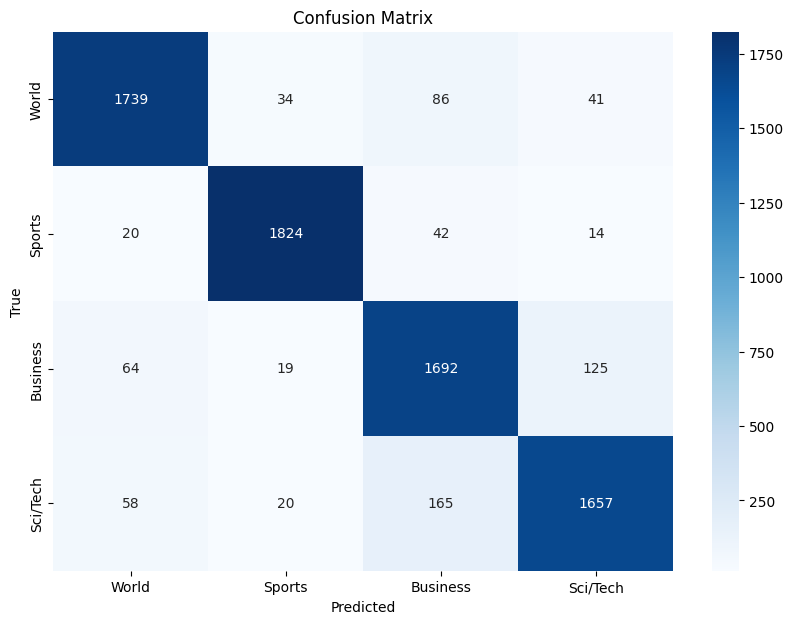

In [16]:
test(model, test_loader, classes)

In [20]:
display_predictions(model, test_loader, tokenizer, classes)

Sample 1
Text: fears for t n pension after talks unions representing workers at turner newall say they are ' disappointed ' after talks with stricken parent firm federal mogul.
True Label: Business
Predicted Probabilities:
World       0.701925
Sports      0.000007
Business    0.278491
Sci/Tech    0.019577
Sample 2
Text: the race is on : second private team sets launch date for human spaceflight ( space. com ) space. com - toronto, canada - - a second \ team of rocketeers competing for the # 36 ; 10 million ansari
True Label: Sci/Tech
Predicted Probabilities:
World       0.000091
Sports      0.000020
Business    0.001294
Sci/Tech    0.998594
Sample 3
Text: ky. company wins grant to study peptides ( ap ) ap - a company founded by a chemistry researcher at the university of louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids
True Label: Sci/Tech
Predicted Probabilities:
World       0.001040
Sports      0.000078
Business    0.00007

# Resources

- [Attention Is All You Need](https://arxiv.org/pdf/1706.03762)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [Attention And Transformers](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W2D5_AttentionAndTransformers/student/W2D5_Tutorial1.ipynb) from Neuromatch Academy.